In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

# Local imports
import sys
sys.path.append("..")

from src.model import MLPClassifier, SimpleCNN
from src.train import train_model
from src.utils import (
    LABELS, ensure_dir, set_seed, predict_all, softmax_probs,
    confusion, per_class_accuracy, make_cost_matrix, cost_weighted_accuracy
)

set_seed(42)

RESULTS_DIR = "../results"
ensure_dir(RESULTS_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [2]:
transform = transforms.ToTensor()

train_data_full = datasets.FashionMNIST(root="../data", train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root="../data", train=False, download=True, transform=transform)

# Train/Val split (e.g., 55k/5k)
val_size = 5000
train_size = len(train_data_full) - val_size
train_data, val_data = random_split(train_data_full, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

len(train_data), len(val_data), len(test_data)


100%|██████████████████████████████████████| 26.4M/26.4M [00:04<00:00, 5.60MB/s]
100%|███████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 178kB/s]
100%|██████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 2.53MB/s]
100%|██████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 5.15MB/s]


(55000, 5000, 10000)

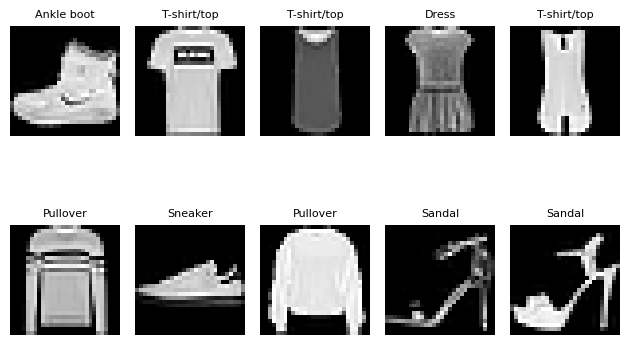

In [3]:
def show_samples(dataset, n=10):
    plt.figure()
    for i in range(n):
        x, y = dataset[i]
        plt.subplot(2, 5, i+1)
        plt.imshow(x.squeeze(0), cmap="gray")
        plt.title(LABELS[y], fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_data_full, n=10)


In [4]:
experiments = [
    {
        "name": "MLP_baseline",
        "model_fn": lambda: MLPClassifier(hidden_sizes=(128, 64), dropout=0.0, use_batchnorm=False, activation="relu"),
        "epochs": 10,
        "lr": 1e-3,
        "opt": "adam",
        "weight_decay": 0.0
    },
    {
        "name": "MLP_bn_dropout",
        "model_fn": lambda: MLPClassifier(hidden_sizes=(256, 128), dropout=0.3, use_batchnorm=True, activation="leakyrelu"),
        "epochs": 12,
        "lr": 1e-3,
        "opt": "adamw",
        "weight_decay": 1e-4
    },
    {
        "name": "CNN_best",
        "model_fn": lambda: SimpleCNN(dropout=0.25),
        "epochs": 10,
        "lr": 1e-3,
        "opt": "adam",
        "weight_decay": 0.0
    },
]


In [5]:
all_histories = {}
all_models = {}

for exp in experiments:
    print("\n" + "="*80)
    print("Running:", exp["name"])
    model = exp["model_fn"]()
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        epochs=exp["epochs"],
        lr=exp["lr"],
        optimizer_name=exp["opt"],
        weight_decay=exp["weight_decay"],
        grad_clip=1.0
    )
    all_histories[exp["name"]] = history
    all_models[exp["name"]] = model



Running: MLP_baseline
Epoch 01/10 | train loss 0.5794 acc 0.7952 | val loss 0.4538 acc 0.8428 | time 1.2s
Epoch 02/10 | train loss 0.4045 acc 0.8557 | val loss 0.4043 acc 0.8534 | time 1.2s
Epoch 03/10 | train loss 0.3555 acc 0.8715 | val loss 0.3989 acc 0.8536 | time 1.2s
Epoch 04/10 | train loss 0.3249 acc 0.8811 | val loss 0.3697 acc 0.8728 | time 1.2s
Epoch 05/10 | train loss 0.3090 acc 0.8861 | val loss 0.3437 acc 0.8764 | time 1.2s
Epoch 06/10 | train loss 0.2906 acc 0.8923 | val loss 0.3437 acc 0.8812 | time 1.2s
Epoch 07/10 | train loss 0.2763 acc 0.8983 | val loss 0.3259 acc 0.8830 | time 1.2s
Epoch 08/10 | train loss 0.2651 acc 0.9034 | val loss 0.3231 acc 0.8804 | time 1.2s
Epoch 09/10 | train loss 0.2548 acc 0.9060 | val loss 0.3311 acc 0.8814 | time 1.2s
Epoch 10/10 | train loss 0.2456 acc 0.9085 | val loss 0.3464 acc 0.8764 | time 1.2s

Running: MLP_bn_dropout
Epoch 01/12 | train loss 0.5238 acc 0.8162 | val loss 0.3957 acc 0.8526 | time 1.6s
Epoch 02/12 | train loss 0.4

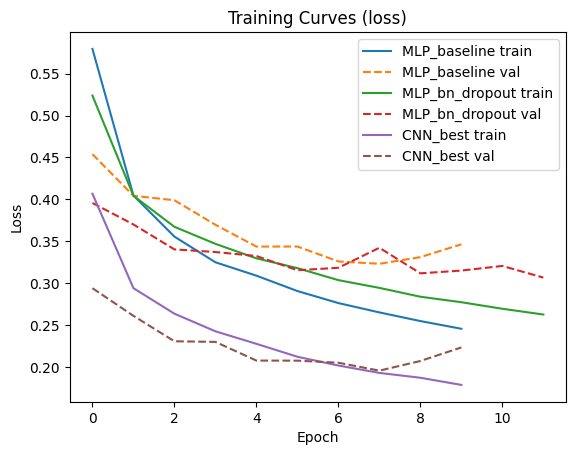

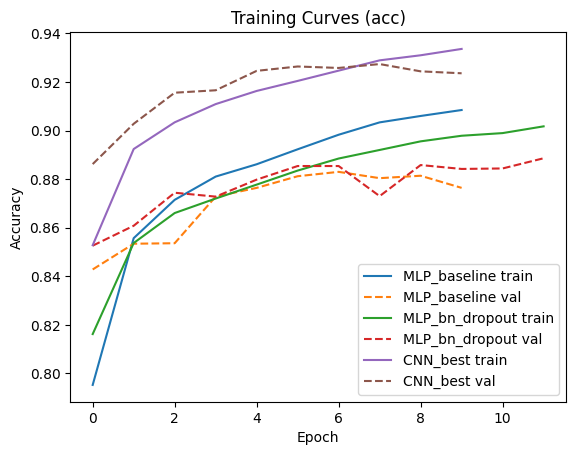

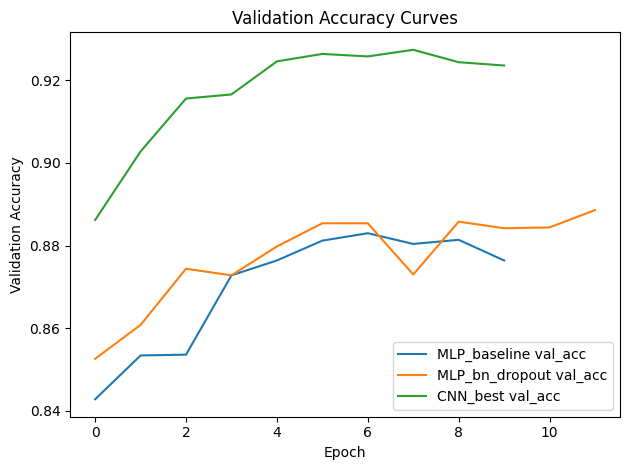

In [6]:
def plot_curves(histories, metric="loss"):
    plt.figure()
    for name, h in histories.items():
        if metric == "loss":
            plt.plot(h["train_loss"], label=f"{name} train")
            plt.plot(h["val_loss"], linestyle="--", label=f"{name} val")
            plt.ylabel("Loss")
        else:
            plt.plot(h["train_acc"], label=f"{name} train")
            plt.plot(h["val_acc"], linestyle="--", label=f"{name} val")
            plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.title(f"Training Curves ({metric})")
    plt.legend()
    plt.show()

plot_curves(all_histories, metric="loss")
plot_curves(all_histories, metric="acc")

# Save a combined curves figure for results/training_curves.png
plt.figure()
for name, h in all_histories.items():
    plt.plot(h["val_acc"], label=f"{name} val_acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Curves")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "training_curves.png"), dpi=200)
plt.show()


In [7]:
best_name = max(all_histories.keys(), key=lambda k: max(all_histories[k]["val_acc"]))
best_name


'CNN_best'

In [8]:
best_model = all_models[best_name].to(device)
test_logits, test_y, test_x = predict_all(best_model, test_loader, device)
test_probs = softmax_probs(test_logits)
test_pred = test_probs.argmax(dim=1).numpy()
test_y_np = test_y.numpy()

test_acc = (test_pred == test_y_np).mean()
test_acc


np.float64(0.9184)

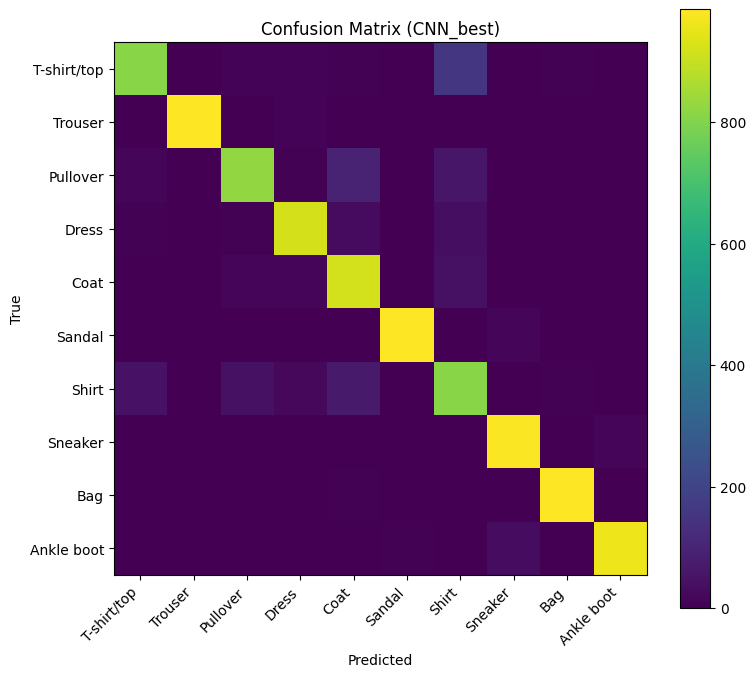

T-shirt/top   acc=0.811
Trouser       acc=0.983
Pullover      acc=0.827
Dress         acc=0.923
Coat          acc=0.918
Sandal        acc=0.984
Shirt         acc=0.809
Sneaker       acc=0.981
Bag           acc=0.986
Ankle boot    acc=0.962

Most confused pairs (top 10 off-diagonal):
T-shirt/top -> Shirt : 156
Pullover -> Coat : 94
Shirt -> Coat : 71
Pullover -> Shirt : 60
Shirt -> T-shirt/top : 49
Shirt -> Pullover : 44
Coat -> Shirt : 44
Dress -> Shirt : 38
Ankle boot -> Sneaker : 33
Dress -> Coat : 27


In [9]:
cm = confusion(test_y_np, test_pred)

plt.figure(figsize=(8, 7))
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix ({best_name})")
plt.colorbar()
ticks = np.arange(10)
plt.xticks(ticks, LABELS, rotation=45, ha="right")
plt.yticks(ticks, LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"), dpi=200)
plt.show()

pc_acc = per_class_accuracy(cm)
for i, a in enumerate(pc_acc):
    print(f"{LABELS[i]:12s}  acc={a:.3f}")

print("\nMost confused pairs (top 10 off-diagonal):")
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)
pairs = []
for t in range(10):
    for p in range(10):
        if t != p and cm_off[t, p] > 0:
            pairs.append((cm_off[t, p], t, p))
pairs.sort(reverse=True)
for c, t, p in pairs[:10]:
    print(f"{LABELS[t]} -> {LABELS[p]} : {c}")


In [10]:
print(classification_report(test_y_np, test_pred, target_names=LABELS, digits=4))


              precision    recall  f1-score   support

 T-shirt/top     0.9205    0.8110    0.8623      1000
     Trouser     0.9980    0.9830    0.9904      1000
    Pullover     0.9118    0.8270    0.8673      1000
       Dress     0.9295    0.9230    0.9262      1000
        Coat     0.8189    0.9180    0.8656      1000
      Sandal     0.9909    0.9840    0.9875      1000
       Shirt     0.7275    0.8090    0.7661      1000
     Sneaker     0.9543    0.9810    0.9675      1000
         Bag     0.9870    0.9860    0.9865      1000
  Ankle boot     0.9806    0.9620    0.9712      1000

    accuracy                         0.9184     10000
   macro avg     0.9219    0.9184    0.9191     10000
weighted avg     0.9219    0.9184    0.9191     10000



In [11]:
cost_matrix = make_cost_matrix()
cwa = cost_weighted_accuracy(test_y_np, test_pred, cost_matrix)

print("Standard test accuracy:", round(float(test_acc), 4))
print("Cost-weighted accuracy:", round(float(cwa), 4))

# Also show average cost per item
avg_cost = np.mean([cost_matrix[t, p] for t, p in zip(test_y_np, test_pred)])
print("Average cost per item:", round(float(avg_cost), 4))


Standard test accuracy: 0.9184
Cost-weighted accuracy: 0.9464
Average cost per item: 0.118


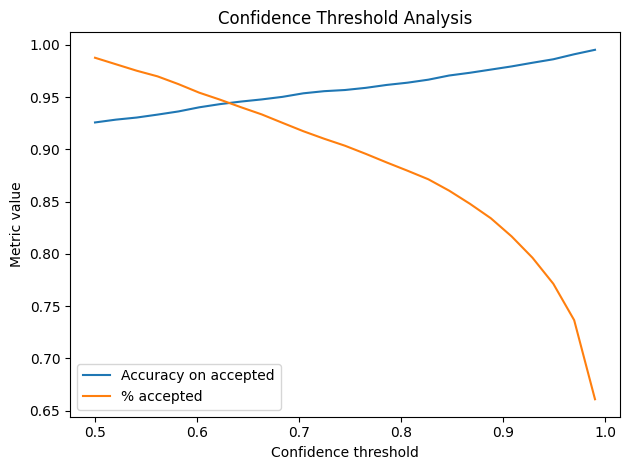

Threshold: 0.8
% needing human review: 0.1177
Accuracy on accepted: 0.9632


In [12]:
conf = test_probs.max(dim=1).values.numpy()
pred = test_pred
true = test_y_np

thresholds = np.linspace(0.5, 0.99, 25)
accepted_pct = []
accepted_acc = []

for th in thresholds:
    mask = conf >= th
    accepted = mask.mean()
    accepted_pct.append(accepted)
    if mask.sum() == 0:
        accepted_acc.append(np.nan)
    else:
        accepted_acc.append((pred[mask] == true[mask]).mean())

plt.figure()
plt.plot(thresholds, accepted_acc, label="Accuracy on accepted")
plt.plot(thresholds, accepted_pct, label="% accepted")
plt.xlabel("Confidence threshold")
plt.ylabel("Metric value")
plt.title("Confidence Threshold Analysis")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "confidence_threshold.png"), dpi=200)
plt.show()

# Example: >0.80
th = 0.80
mask = conf >= th
print("Threshold:", th)
print("% needing human review:", round(float(1 - mask.mean()), 4))
print("Accuracy on accepted:", round(float((pred[mask] == true[mask]).mean()), 4))


In [13]:
# Find misclassified indices
mis_idx = np.where(pred != true)[0]
len(mis_idx)


816

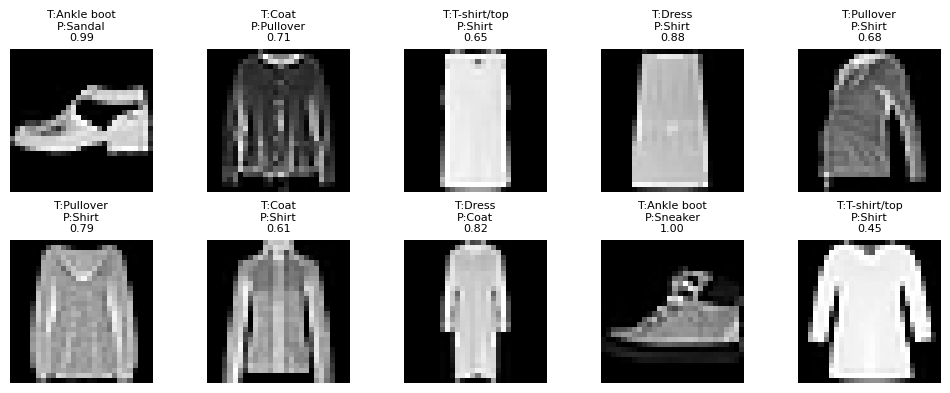

In [14]:
# Show 10 misclassified with predicted/true/confidence
k = 10
show_idx = mis_idx[:k]

plt.figure(figsize=(10, 4))
for i, idx in enumerate(show_idx):
    img = test_x[idx].squeeze(0).numpy()
    t = true[idx]
    p = pred[idx]
    c = conf[idx]
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{LABELS[t]}\nP:{LABELS[p]}\n{c:.2f}", fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "misclassified_examples.png"), dpi=200)
plt.show()
